In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
from torch import nn

In [2]:
RANDOM_STATE = 42

In [35]:
rcParams['figure.figsize'] = (13, 7)

In [25]:
class DocumentPartClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings,
        hidden_size,
        num_layers=1,
        embedding_dim=256,
        dropout=0,
        bidirectional=False
    ):
        super().__init__()

        self.embedding = torch.nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            padding_idx=0,
        )
        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True,
        )
        self.project = torch.nn.Linear(
            hidden_size, 1
        )
        self.softmax = torch.nn.Softmax(1)

    def forward(self, batch):
        output, _ = (self.lstm(self.embedding(batch)))

        return self.softmax(self.project(output)).flatten(1)

Обучение

In [84]:
import json

from document_dataset import LabeledDocumentDataset, DocumentDataset


with open('word_idx.json') as f:
    word_idx = json.load(f)


with open('first_label_train.json') as first_train, open('first_label_test.json') as first_test:
    first_train_dataset = LabeledDocumentDataset(json.load(first_train), word_idx, max_document_length=800)
    first_test_dataset = LabeledDocumentDataset(json.load(first_test), word_idx, max_document_length=800)

# собрать mapping по всему корпусу; mapping должен быть одинаковым у обоих

In [110]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(first_train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(first_test_dataset, batch_size=32)

In [60]:
def calculate_accuracy(y_true, y_pred):
    pass


def calculate_label_accuracy(y_true, y_pred):
    true_pred = np.all(y_true == y_pred, axis=1).sum()

    return true_pred / len(y_true)

In [74]:
from IPython.display import clear_output


def show_training(losses, train_scores, test_scores):
    clear_output(True)

    plt.figure(figsize=[16, 9])

    plt.subplot(2, 2, 1)
    plt.title("Loss")
    plt.plot(losses, label='Cross Entropy')
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.title("Accuracy")
    plt.plot(train_scores, label='train')
    plt.plot(test_scores, label='test')
    plt.grid()

    plt.legend()

    plt.show()

In [195]:
def evaluate_metric(clf, dataloader):
    correct_predictions = 0
    for text_batch, label_batch, start_batch, end_batch in dataloader:
        with torch.no_grad():
            y_pred = clf(text_batch).detach().numpy()
        predicted_labels = np.eye(y_pred.shape[1])[np.argmax(y_pred, axis=1)]
        batch_correct_predictions = np.all(start_batch.numpy() == predicted_labels, axis=1).sum()
        correct_predictions += batch_correct_predictions

    return correct_predictions / len(dataloader.dataset)


def evaluate_metrics(clf, train_dataset, test_dataset):
    return evaluate_metric(clf, train_dataset), evaluate_metric(clf, test_dataset)

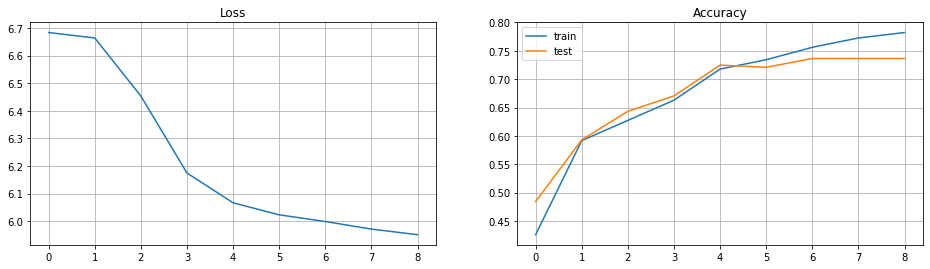

KeyboardInterrupt: 

In [196]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm.notebook import tqdm


first_clf = DocumentPartClassifier(first_train_dataset.tokens_count, 50, embedding_dim=64)

n_epoch = 50

optimizer = Adam(params=first_clf.parameters())
loss = CrossEntropyLoss()

losses = []
train_scores = []
test_scores = []

for epoch in range(n_epoch):
    batch_losses = []
    for text_batch, label_batch, start_batch, end_batch in train_dataloader:
        optimizer.zero_grad()

        y_pred = first_clf(text_batch)
        output = loss(y_pred, start_batch)

        batch_losses.append(output.item())

        output.backward()
        optimizer.step()

    epoch_train_acc, epoch_test_acc = evaluate_metrics(first_clf, train_dataloader, test_dataloader)
    losses.append(np.mean(batch_losses))
    train_scores.append(epoch_train_acc)
    test_scores.append(epoch_test_acc)

    show_training(losses, train_scores, test_scores)